Aside from the head, the MPII Dataset does not include bounding box coordinates (we won't be using the head bounding box anyways). Thus, I will need to write some code that can approximate the coordinates for limbs using the existing joint coordinates in the dataset.

First, get the images.

In [1]:
from google.colab import drive
import shutil
import pandas as pd, csv
from tqdm.auto import tqdm
import math

In [2]:
drive.mount('/content/drive')
with open(f'/content/drive/My Drive/CPEN 291 Datasets/Sports_Dataset/sports_annotations_no_box.csv', 'r'):
  shutil.copy("/content/drive/My Drive/CPEN 291 Datasets/Sports_Dataset/sports_annotations_no_box.csv", "sports_annotations_no_box.csv")

dataset = pd.read_csv('sports_annotations_no_box.csv')
imgs = set()
for i in dataset.index:
  imgs.add(dataset["NAME"][i])

Mounted at /content/drive


In [3]:

with open('/content/drive/My Drive/CPEN 291 Datasets/Sports_Dataset/images.tar.gz', 'r'):
  shutil.copy('/content/drive/My Drive/CPEN 291 Datasets/Sports_Dataset/images.tar.gz', 'images.tar.gz')

drive.flush_and_unmount()

In [4]:
!tar xfz images.tar.gz

In [5]:
import os
print(len(os.listdir('images_data')))

9002


In [6]:
dataset

,Unnamed: 0,Unnamed: 0.1,NAME,r ankle_X,r ankle_Y,r knee_X,r knee_Y,r hip_X,r hip_Y,l hip_X,l hip_Y,l knee_X,l knee_Y,l ankle_X,l ankle_Y,pelvis_X,pelvis_Y,thorax_X,thorax_Y,upper neck_X,upper neck_Y,head top_X,head top_Y,r wrist_X,r wrist_Y,r elbow_X,r elbow_Y,r shoulder_X,r shoulder_Y,l shoulder_X,l shoulder_Y,l elbow_X,l elbow_Y,l wrist_X,l wrist_Y,Scale,Activity,Category
0,0,0,015601864.jpg,620,394,616,269,573,185,647,188,661,221,656,231,610,187,647,176,637.0201,189.8183,695.9799,108.1817,606,217,553,161,601,167,692,185,693,240,688,313,3.021046,curling,sports
1,1,0,015599452.jpg,-1,-1,-1,-1,806,543,720,593,-1,-1,-1,-1,763,568,683,290,682.0000,256.0000,676.0000,68.0000,563,296,555,410,647,281,719,299,711,516,545,466,5.641276,curling,sports
2,2,0,005808361.jpg,804,711,816,510,908,438,1040,454,906,528,883,707,974,446,985,253,982.7591,235.9694,962.2409,80.0306,869,214,798,340,902,253,1067,253,1167,353,1142,478,4.718488,curling,sports
3,3,0,086617615.jpg,301,461,305,375,201,340,294,342,335,370,331,455,248,341,279,263,277.0210,268.7786,305.9790,184.2214,328,354,260,335,244,261,314,264,327,320,362,346,2.681349,curling,sports
4,4,0,060111501.jpg,980,322,896,318,865,248,943,226,948,290,881,349,904,237,858,135,871.1877,180.4244,835.8123,58.5756,772,294,754,247,792,147,923,123,995,163,961,223,3.806403,curling,sports
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8997,17311,0,012741552.jpg,855,305,860,233,850,167,871,173,878,245,853,299,861,170,879,115,883.5063,107.4895,904.4937,72.5105,870,170,837,146,860,105,898,125,894,166,900,195,1.223765,"moto-cross, off-road motor sports, all-terrain...",sports
8998,17312,0,089258378.jpg,542,298,623,214,608,132,650,165,664,256,588,359,629,149,741,92,740.1674,92.2345,812.8326,71.7655,674,175,640,121,715,87,766,96,736,154,755,220,2.264791,"moto-cross, off-road motor sports, all-terrain...",sports
8999,17313,0,076912890.jpg,761,679,756,618,756,551,807,561,801,634,796,711,782,556,767,406,765.6631,390.9975,759.3369,320.0025,610,323,645,368,711,391,822,420,855,501,860,567,2.138291,"moto-cross, off-road motor sports, all-terrain...",sports
9000,17314,0,099616030.jpg,704,336,693,284,744,281,742,301,685,323,696,363,743,291,775,250,775.1853,238.3288,775.8147,198.6712,716,238,759,252,776,240,773,259,766,292,739,281,1.189877,"moto-cross, off-road motor sports, all-terrain...",sports


Next, view the existing coordinates.

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

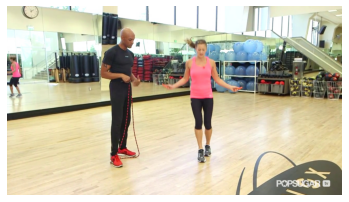

In [8]:
im = plt.imread("images_data/000003072.jpg")
plt.axis('off')
plt.imshow(im)

In [9]:
# Will edit to be more efficient when saving a csv with bounding boxes later
index = -1
for i in dataset.index:
  if dataset["NAME"][i] == "000003072.jpg":
    print(i)
    index = i
    break

1600


In [10]:
# Note, does not take into account when the joints aren't in view (those are stored as -1). This is just a testing function
def show_points(index, table):
  im = table["NAME"][index]
  im = plt.imread(f"images_data/{im}")
  plt.axis('off')
 
  plt.scatter([dataset["r ankle_X"][i]], [dataset["r ankle_Y"][i]], s=5)
  plt.scatter([dataset["r knee_X"][i]], [dataset["r knee_Y"][i]], s=5)
  plt.scatter([dataset["r hip_X"][i]], [dataset["r hip_Y"][i]], s=5)
  plt.scatter([dataset["l hip_X"][i]], [dataset["l hip_Y"][i]], s=5)
  plt.scatter([dataset["l knee_X"][i]], [dataset["l knee_Y"][i]], s=5)
  plt.scatter([dataset["l ankle_X"][i]], [dataset["l ankle_Y"][i]], s=5)
  plt.scatter([dataset["pelvis_X"][i]], [dataset["pelvis_Y"][i]], s=5)
  plt.scatter([dataset["thorax_X"][i]], [dataset["thorax_Y"][i]], s=5)
  plt.scatter([dataset["upper neck_X"][i]], [dataset["upper neck_Y"][i]], s=5)
  plt.scatter([dataset["head top_X"][i]], [dataset["head top_Y"][i]], s=5)
  plt.scatter([dataset["r wrist_X"][i]], [dataset["r wrist_Y"][i]], s=5)
  plt.scatter([dataset["r elbow_X"][i]], [dataset["r elbow_Y"][i]], s=5)
  plt.scatter([dataset["r shoulder_X"][i]], [dataset["r shoulder_Y"][i]], s=5)
  plt.scatter([dataset["l shoulder_X"][i]], [dataset["l shoulder_Y"][i]], s=5)
  plt.scatter([dataset["l elbow_X"][i]], [dataset["l elbow_Y"][i]], s=5)
  plt.scatter([dataset["l wrist_X"][i]], [dataset["l wrist_Y"][i]], s=5)
  plt.imshow(im)

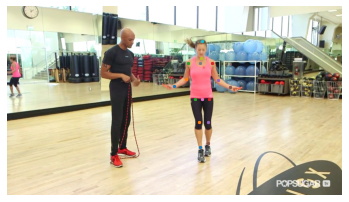

In [11]:
show_points(index, dataset)

Based on some preliminary observations, a rough approximation for the width of, for example, an upper arm is about half its length. I must also take the angle from one point to the other into account.

In [64]:

def box_from_coords(a, b): #a and b are coordinate tuples
  if a[0] == -1 or a[1] == -1 or b[0] == -1 or b[1] == -1:
    return -1, -1, -1, -1
  xl = min(a[0], b[0])
  yd = min(a[1], b[1])
  xs = abs(a[0] - b[0])
  ys = abs(a[1] - b[1])

  length = math.sqrt((ys*ys) + (xs*xs))
  # Want a minimum width in respect to length
  minW = minH = length / 2
  if minW > xs:
    # xs = minW
    xl = max(0, xl - minW/2)
    xs = max(abs(b[0]-xl), abs(a[0]-xl), minW)
  if minH > ys:
    # ys = minH
    yd = max(0, yd - minH/2)
    ys = max(abs(b[1]-yd), abs(a[1]-yd), minH)
  return xl, yd, xs, ys

def box_from_coords_torso(l_shoulder, r_shoulder, l_hip, r_hip): # Special case
  if (l_shoulder == (-1, -1) and r_hip == (-1, -1)) and (r_shoulder == (-1, -1) and l_hip == (-1, -1)):
    return -1, -1, -1, -1 # If the joints are obscured to this extent, it's not worth including

  x = y = w = h = -1
  if l_shoulder != (-1, -1):
    if r_shoulder != (-1, -1):
      x = min(l_shoulder[0], r_shoulder[0])
      y = min(l_shoulder[1], r_shoulder[1])
      w = abs(r_shoulder[0]-l_shoulder[0])
      h = abs(r_shoulder[1]-l_shoulder[1])
    if l_hip != (-1, -1):
      if x == -1:
        x = min(l_shoulder[0], l_hip[0])
      else:
        x = min(x, l_hip[0])
      if y == -1:
        y = min(l_shoulder[1], l_hip[1])
      else:
        y = min(y, l_hip[1])
      w = max(w, abs(l_shoulder[0]-l_hip[0]))
      h = max(h, abs(l_shoulder[1]-l_hip[1]))
    # if r_hip != (-1, -1): Don't need this line as the first check at the top does it
    if x == -1:
      x = min(l_shoulder[0], r_hip[0])
    else:
      x = min(x, r_hip[0])
    if y == -1:
      y = min(l_shoulder[1], r_hip[1])
    else:
      y = min(y, r_hip[1])
    w = max(w, abs(l_shoulder[0]-r_hip[0]))
    h = max(h, abs(l_shoulder[1]-r_hip[1]))
  elif r_shoulder != (-1, -1):
    # if l_hip != (-1, -1):
    x = min(r_shoulder[0], l_hip[0])
    y = min(r_shoulder[1], l_hip[1])
    w = abs(r_shoulder[0]-l_hip[0])
    h = abs(r_shoulder[1]-l_hip[1])
    if r_hip != (-1, -1):
      if x == -1:
        x = min(r_shoulder[0], r_hip[0])
      else:
        x = min(x, r_hip[0])
      if y == -1:
        y = min(r_shoulder[1], r_hip[1])
      else:
        y = min(y, l_hip[1])
      w = max(w, abs(r_shoulder[0]-r_hip[0]))
      h = max(h, abs(r_shoulder[1]-r_hip[1]))

  return box_from_coords((x,y), (x+w, y+h))



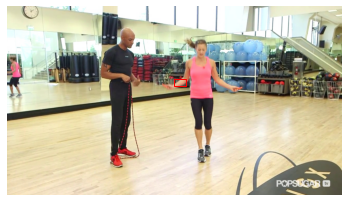

In [65]:
im = plt.imread("images_data/000003072.jpg")
xl, yd, xs, ys = box_from_coords((dataset["r elbow_X"][index], dataset["r elbow_Y"][index]), (dataset["r wrist_X"][index], dataset["r wrist_Y"][index]))
plt.imshow(im)
plt.axis('off')
ax = plt.gca()
box = patches.Rectangle((xl, yd), xs, ys, ec='r', fc='none')
ax.add_patch(box)

Now to reformat the dataset.

In [66]:
box_from_coords((dataset["l ankle_X"][0], dataset["l ankle_Y"][0]), (dataset["l knee_X"][0], dataset["l knee_Y"][0]))

(653.2049150281252, 221, 7.795084971874758, 10)

In [67]:
l_shin = []
r_shin = []
l_thigh = []
r_thigh = []
torso = []
l_forearm = []
r_forearm = []
l_uparm = []
r_uparm = []
ims = []

for i in dataset.index:
  l_shin.append(box_from_coords((dataset["l ankle_X"][i], dataset["l ankle_Y"][i]), (dataset["l knee_X"][i], dataset["l knee_Y"][i])))
  r_shin.append(box_from_coords((dataset["r ankle_X"][i], dataset["r ankle_Y"][i]), (dataset["r knee_X"][i], dataset["r knee_Y"][i])))
  l_thigh.append(box_from_coords((dataset["l hip_X"][i], dataset["l hip_Y"][i]), (dataset["l knee_X"][i], dataset["l knee_Y"][i])))
  r_thigh.append(box_from_coords((dataset["r hip_X"][i], dataset["r hip_Y"][i]), (dataset["r knee_X"][i], dataset["r knee_Y"][i])))
  torso.append(box_from_coords_torso((dataset["l shoulder_X"][i], dataset["l shoulder_Y"][i]), (dataset["r shoulder_X"][i], dataset["r shoulder_Y"][i]), (dataset["l hip_X"][i], dataset["l hip_Y"][i]), (dataset["r hip_X"][i], dataset["r hip_Y"][i])))
  l_forearm.append(box_from_coords((dataset["l elbow_X"][i], dataset["l elbow_Y"][i]), (dataset["l wrist_X"][i], dataset["l wrist_Y"][i])))
  r_forearm.append(box_from_coords((dataset["r elbow_X"][i], dataset["r elbow_Y"][i]), (dataset["r wrist_X"][i], dataset["r wrist_Y"][i])))
  l_uparm.append(box_from_coords((dataset["l shoulder_X"][i], dataset["l shoulder_Y"][i]), (dataset["l elbow_X"][i], dataset["l elbow_Y"][i])))
  r_uparm.append(box_from_coords((dataset["r shoulder_X"][i], dataset["r shoulder_Y"][i]), (dataset["r elbow_X"][i], dataset["r elbow_Y"][i])))
  ims.append(dataset["NAME"][i])


In [68]:
data = {
    "l_shin": l_shin,
    "r_shin": r_shin,
    "l_thigh": l_thigh,
    "r_thigh": r_thigh,
    "torso": torso,
    "l_forearm": l_forearm,
    "r_forearm": r_forearm,
    "l_uparm": l_uparm,
    "r_uparm": r_uparm,
}
df = pd.DataFrame(data, index=ims)

In [69]:
df

,l_shin,r_shin,l_thigh,r_thigh,torso,l_forearm,r_forearm,l_uparm,r_uparm
015601864.jpg,"(653.2049150281252, 221, 7.795084971874758, 10)","(584.7340040939042, 269, 62.53199181219162, 125)","(638.0382758355325, 188, 22.961724164467455, 33)","(549.4084231133229, 185, 66.5915768866771, 84)","(573, 136.91158860956597, 119, 60.17682278086805)","(669.7072418700733, 240, 36.585516259853435, 73)","(553, 161, 53, 56)","(678.247727460525, 185, 27.504545078950134, 55)","(553, 148.90661337755216, 48, 24.186773244895647)"
015599452.jpg,"(-1, -1, -1, -1)","(-1, -1, -1, -1)","(-1, -1, -1, -1)","(-1, -1, -1, -1)","(570.3494129180996, 281, 163.65058708190043, 294)","(545, 422.6583341344613, 166, 93.34166586553869)","(526.4299107456767, 296, 57.14017850864661, 114)","(656.7131461585772, 299, 108.57370768284558, 217)","(555, 281, 92, 129)"
005808361.jpg,"(837.8820988963361, 528, 90.23580220732788, 179)","(753.6605274163505, 510, 100.678945167299, 201)","(906, 415.7312137636951, 134, 112.26878623630489)","(816, 438, 92, 72)","(902, 253, 165, 201)","(1110.131128040045, 353, 63.73774391990981, 125)","(761.8432233184428, 214, 107.15677668155718, 126)","(1067, 253, 100, 100)","(798, 253, 104, 87)"
086617615.jpg,"(309.7264836004952, 370, 42.547032799009614, 85)","(279.4767567499691, 375, 43.04648650006177, 86)","(294, 342, 41, 28)","(201, 312.5671273833745, 104, 62.4328726166255)","(201, 261, 113, 78)","(327, 320, 35, 26)","(260, 317.34886689189614, 68, 36.65113310810386)","(299.6277176481952, 264, 28.74456470360962, 56)","(225.0725067692523, 261, 37.8549864614954, 74)"
060111501.jpg,"(881, 290, 67, 59)","(896, 296.97620395837134, 84, 42.04759208325728)","(926.951246154296, 226, 32.09750769140807, 64)","(845.8607079545768, 248, 50.13929204542319, 70)","(792, 123, 131, 125)","(943.7590603504333, 163, 51.24093964956671, 60)","(741.4177704678384, 247, 30.58222953216159, 47)","(923, 102.408739718026, 72, 60.591260281974)","(727.2558417593673, 147, 64.74415824063271, 100)"
...,...,...,...,...,...,...,...,...,...
012741552.jpg,"(838.1234244531881, 245, 39.876575546811864, 54)","(836.9566494242339, 233, 36.08670115153226, 72)","(852.9151306335932, 173, 36.16973873281365, 72)","(833.3116807317214, 167, 33.37663853655727, 66)","(850, 105, 48, 48)","(886.5964535525196, 166, 14.807092894960848, 29)","(837, 146, 33, 24)","(883.7013350379771, 125, 20.59732992404598, 41)","(825.2473407264569, 105, 34.752659273543145, 41)"
089258378.jpg,"(588, 256, 76, 103)","(542, 214, 81, 84)","(626.9823437335597, 165, 46.03531253288067, 91)","(587.1598344536326, 132, 41.68033109273485, 82)","(608, 43.89765087608333, 158, 112.10234912391667)","(718.8298951663072, 154, 36.17010483369279, 66)","(640, 121, 34, 54)","(719.6751722826855, 96, 46.32482771731452, 58)","(640, 66.41329312395982, 75, 54.58670687604018)"
076912890.jpg,"(776.7094582761396, 634, 38.58108344772085, 77)","(740.6988562519007, 618, 30.602287496198713, 61)","(782.68845992277, 561, 36.62308015445998, 73)","(739.25, 551, 33.5, 67)","(711, 391, 111, 141)","(838.4527192566271, 501, 33.094561486745825, 66)","(610, 323, 35, 45)","(800.1339303943302, 420, 54.86606960566985, 81)","(645, 350.52680624499345, 66, 40.47319375500655)"
099616030.jpg,"(674.6287657436542, 323, 21.371234256345815, 40)","(679.7123177340817, 284, 26.575364531836623, 52)","(685, 285.7254296296099, 57, 37.27457037039011)","(693, 268.2279602255552, 51, 25.544079548889602)","(742, 240, 31, 42)","(739, 273.7113101314434, 27, 18.288689868556617)","(716, 226.694580945405, 43, 25.305419054595006)","(757.5664361032835, 259, 16.867127793433, 33)","(759, 240, 17, 12)"


Now to test how the bounding boxes look.

In [70]:
df.loc["015601864.jpg", "l_shin"]

(653.2049150281252, 221, 7.795084971874758, 10)

In [71]:
df.loc["015601864.jpg", "l_shin"][0]

653.2049150281252

In [72]:
cols = ["l_shin", "r_shin", "l_thigh", "r_thigh", "torso", "l_forearm", "r_forearm", "l_uparm", "r_uparm"]
count = 0
for i in df.index:
  fig = plt.figure()
  im = plt.imread(f"images_data/{i}")
  plt.axis('off')
  plt.imshow(im)
  ax = plt.gca()
  for c in cols:
    s = df.loc[i, c]   
    box = patches.Rectangle((s[0], s[1]), s[2], s[3], ec='r', fc='none')
    ax.add_patch(box)
  fig.show()
  count+=1
  if count == 20: break

Output hidden; open in https://colab.research.google.com to view.

From the samples above, it's obvious that they're not as good as what someone manually annotating would be able to do. However, since the project's purpose is to blur something in motion we only need a "good enough" approximation of where the limbs are. With this in mind, the processed results are pretty good. The main issue would be the body parts obscured behind other body parts being labeled as well.